In [1]:
import scipy.io as sio
from scipy import optimize
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import data_helpers
import copy
from math import sin, atan

### Classify Data Points

In [2]:
df = data_helpers.clean_data([sio.loadmat("tire_data/RunData_10inch_Cornering_Matlab_SI_Round6/B1654run22.mat")])

variable_sweeps = {"load" : {"sweep" : np.array([-250, -200, -150, -100, -50]) / 0.224809, "label" : "FZ" },
                    "camber" : {"sweep" : np.array([0, 2, 4]), "label" : "IA"},
                    "pressure" : {"sweep" : np.array([8, 10, 12, 14]) * 6.89476, "label" : "P"},
                    "velocity" : {"sweep" : np.array([15, 25, 45]) * 1.60934, "label" : "V"}}

for variable, info in variable_sweeps.items():
    temp_nearest_func = lambda x: data_helpers.get_nearest_value(info["sweep"], x)
    df[variable] = df[info["label"]].apply(temp_nearest_func)

### Count Number of Points for Each Sweep

In [3]:
for variable, info in variable_sweeps.items():
    count = df.groupby([variable])[variable].count()
    variable_sweeps[variable]["count"] = count

### Choose Most Common Sweep Variable for Each Sweep for Analysis

In [4]:
temp_df = copy.copy(df)
for variable, info in variable_sweeps.items():
    if variable != "load":
        temp_df = temp_df[temp_df[variable] == info["count"].idxmax()]

### Define Pajeka Fit Formula

In [5]:
def pajeka_lat_forc_94(X, E, C, B, D):
    x = [row["FZ"] * D * sin(C * atan(B * row["SA"] - E * (B * row["SA"] - atan(B * row["SA"])))) for _, row in X.iterrows()]
    return x

In [6]:
def pajeka_lat_forc_test(slip_angles, E, C, B, D, Sv):
    x = [D * sin(C * atan(B * x - E * (B * x - atan(B * x)))) + Sv for x in slip_angles]
    return x

In [7]:
def pajeka_lat_forc(slip_angles, E, C, B, D, Sh, Sv):
    thetas = [(1 - E) * (x + Sh) + E / B * atan(B * (x + Sh)) for x in slip_angles]
    return [D*sin(C * atan(B * x)) + Sv for x in thetas]

In [8]:
def arctan_lat_fit(X, A, B, C, D):
    return [row["FZ"] * A * atan(B * row["SA"] + D) + C for _, row in X.iterrows()]

## Compare Fit to Raw Data (ArcTangent)

In [9]:
output0 = optimize.curve_fit(arctan_lat_fit, temp_df, temp_df["FY"])
print("Coefficients:", *output0[0])

Coefficients: 1.8917656099190407 0.35094226822401187 -13.884224233895088 -0.03698989169508984


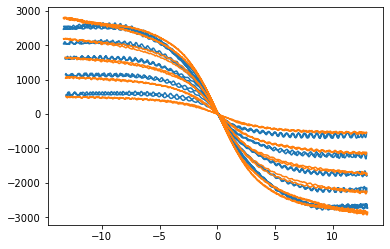

In [10]:
plt.plot(temp_df["SA"], temp_df["FY"])
plt.plot(temp_df["SA"], arctan_lat_fit(temp_df, *output0[0]))
plt.show()

In [11]:
squared_errors = (abs(temp_df["FY"] - arctan_lat_fit(temp_df, *output0[0])))**2
print("Standard Deviation from Fit (Newtons):", (sum(squared_errors)/len(squared_errors))**0.5 )

Standard Deviation from Fit (Newtons): 116.66523100672042


## Compare Fit to Raw Data (Pajecka 94)

In [14]:
output = optimize.curve_fit(pajeka_lat_forc_94, temp_df, temp_df["FY"])
print("Coefficients:",*output[0])

NameError: name 'pajeka_lat_forc_94' is not defined

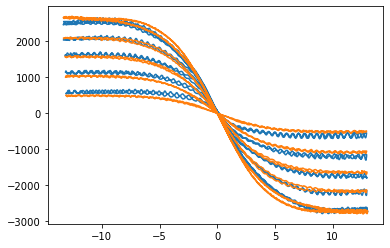

In [13]:
plt.plot(temp_df["SA"], temp_df["FY"])
plt.plot(temp_df["SA"], pajeka_lat_forc_94(temp_df, *output[0]))
plt.show()

### Error Analysis for Pacejka 94 - 4 Coefficient

In [14]:
squared_errors = (abs(temp_df["FY"] - pajeka_lat_forc_94(temp_df, *output[0])))**2
print("Standard Deviation from Fit (Newtons):", (sum(squared_errors)/len(squared_errors))**0.5 )

Standard Deviation from Fit (Newtons): 110.58667607924347


## Compare Fit to Raw Data (Full Pacejka)

In [7]:
temp_df2 = temp_df[temp_df["load"] == variable_sweeps["load"]["count"].idxmax()]

In [81]:
temp_df2 = temp_df[temp_df["load"] == variable_sweeps["load"]["count"].idxmax()]
output2 = optimize.curve_fit(pajeka_lat_forc_test, temp_df2["FY"], temp_df2["SA"], maxfev=10000)
print("Coefficients:",*output2[0])

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

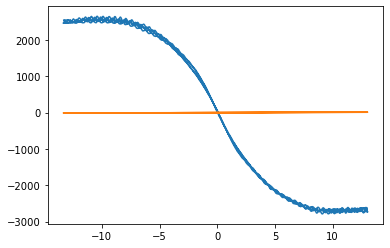

In [69]:
plt.plot(temp_df2["SA"], temp_df2["FY"])
plt.plot(temp_df2["SA"], pajeka_lat_forc_test(temp_df2["FY"], *output2[0]))

# input_angles = [i/10 for i in range(-130, 131)]
# coefficients = [0.37849796007995107, 1.6402969387650528, 0.14421226713755966, -1000*2.452789904167964, 0, 0]
# y = pajeka_lat_forc(input_angles, *coefficients)
# plt.plot(input_angles, y)
plt.show()

In [47]:
squared_errors = (abs(temp_df["FY"] - pajeka_lat_forc(temp_df["SA"], *coefficients)))**2
print("Standard Deviation from Fit (Newtons):", (sum(squared_errors)/len(squared_errors))**0.5 )

Standard Deviation from Fit (Newtons): 798.284448941123


In [60]:
output3 = optimize.curve_fit(pajeka_lat_forc, temp_df2["FY"], temp_df2["SA"], [0.3784, 1.6402, 0.1442, -1000*2.4527, 0, 0], maxfev=10000)
print("Coefficients:",*output3[0])

Coefficients: 850088.2638854474 0.0003568172320452359 -4.1104377308955086e-06 -85283.3846667334 96.31447124277399 0.28412981724969627


### Testing Data Oscillation Removal

In [10]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [13]:
plt.plot(temp_df2["SA"], temp_df2["FY"])
plt.plot(movingaverage(temp_df2["FY"], 5), temp_df["SA"])

ValueError: x and y must have same first dimension, but have shapes (2556,) and (7670,)